In [ ]:
"""
Different rom other basic models
Dropout Regularization:

Added a dropout layer (Dropout(0.5)) after the dense layer to reduce overfitting by randomly dropping 50% of the neurons during training.
Early Stopping:

Implemented early stopping to stop training when the validation loss stops improving. The model restores the best weights from the point with the lowest validation loss.
Reduced Batch Size:

Reduced the batch size to 16 (from 32) to help the model learn more stable features, especially useful for small datasets.
    Increased Epochs with Early Stopping:

Increased the number of epochs to 50 to allow the model more time to learn, but early stopping will prevent overfitting by stopping the training when performance on the validation set stops improving."""

Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration: With Data Augmentation and Dropout
Test Accuracy: 60.47%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

Summary of Results:
Configuration 1: With Data Augmentation and Dropout
Test Accuracy: 60.47%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


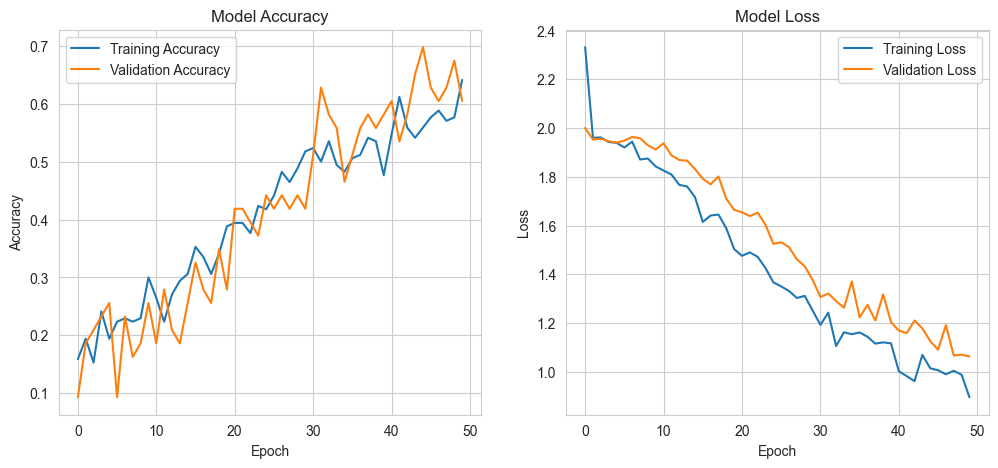

In [9]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function with dropout for regularization
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # Add dropout to reduce overfitting
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# Data augmentation configuration with increased augmentation
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False
)

print(f"Running configuration: With Data Augmentation and Dropout")

# Create the model
model = create_model()

# Fit the data generator to the training data
datagen.fit(X_train)

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16, seed=42),
    validation_data=(X_test, y_test),
    epochs=50,  # Increased number of epochs to allow for early stopping
    class_weight=class_weights_dict,
    callbacks=[early_stopping],  # Add early stopping
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'Without Data Augmentation and Dropout,earlycallback,reduced batch size',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the JAFEE dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input (64, 64, 1) for grayscale

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the specific augmentation configuration
specific_config = {'shear_range': 0.2, 'zoom_range': 0.0, 'rotation_range': 0,
                   'width_shift_range': 0.0, 'height_shift_range': 0.0,
                   'horizontal_flip': True}

# Initialize list to store results
results = []

# Only run for the specific configuration
print(f"Running configuration: {specific_config}")

# Define the CNN architecture with dropout for regularization
model = Sequential([
    InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
    Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
    Flatten(),  # Flatten the output for the dense layer
    Dense(100, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=specific_config['shear_range'],
    zoom_range=specific_config['zoom_range'],
    rotation_range=specific_config['rotation_range'],
    width_shift_range=specific_config['width_shift_range'],
    height_shift_range=specific_config['height_shift_range'],
    horizontal_flip=specific_config['horizontal_flip']
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Display before-and-after augmentation images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sample_image = X_train[0].reshape(64, 64)

axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title('Original Image')

augmented_image = datagen.random_transform(sample_image.reshape(64, 64, 1))  # Ensure shape is (64, 64, 1)
augmented_image = augmented_image.reshape(64, 64)
axes[1].imshow(augmented_image, cmap='gray')
axes[1].set_title('Augmented Image')

plt.show()

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using class weights and augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16, seed=42),
    validation_data=(X_test, y_test),
    epochs=50,  # Increased number of epochs to allow for early stopping
    class_weight=class_weights_dict,
    callbacks=[early_stopping],  # Add early stopping
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': specific_config,
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score,
    'history': history.history  # Save training history for later plotting
}

# Print the results for this configuration
print(f"Configuration: {config_results['config']}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

# Plot the accuracy and loss for the configuration
history = config_results['history']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Label distribution:


ValueError: zero-size array to reduction operation maximum which has no identity